In [2]:
from collections import Counter
import os

from graphviz import Source
from IPython.display import display, Markdown

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns


In [3]:
from graphviz import Source
import networkx as nx

In [4]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label != 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    print(root_nodes)
    #assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

# Load clone map

In [5]:
pd.set_option('display.max_rows', None)
data = pd.read_csv('../../data/YFV2001_clone_key/YFV2001_clone_key', sep = '\t')
data.head()

clones_map_raw = data.copy()
clones_map_raw

FileNotFoundError: [Errno 2] No such file or directory: '../../data/YFV2001_clone_key/YFV2001_clone_key'

In [6]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

NameError: name 'clones_map_raw' is not defined

In [6]:
all_clones

['bulk', '107', '108', '118', '122', '143', '149']

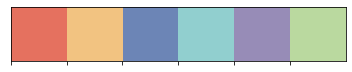

In [7]:
#flatui = ['#E5715F', '#BAD99F', '#6C85B6', '#91CFCF', '#978CB7', '#F2C381'] 
flatui = ['#E5715F', '#F2C381', '#6C85B6', '#91CFCF', '#978CB7', '#BAD99F'] 
sns.palplot(sns.color_palette(flatui))

In [8]:
colors = sns.color_palette(sns.color_palette(flatui))

clone_color = {
    'bulk': (0, 0, 0),
    '107': np.array(colors[0]) * 255,
    '108': np.array(colors[1]) * 255,
    '118': np.array(colors[2]) * 255,
    '122': np.array(colors[3]) * 255,
    '143': np.array(colors[4]) * 255,
    '149': np.array(colors[5]) * 255,
}


In [9]:
clone_color

{'bulk': (0, 0, 0),
 '107': array([229., 113.,  95.]),
 '108': array([242., 195., 129.]),
 '118': array([108., 133., 182.]),
 '122': array([145., 207., 207.]),
 '143': array([151., 140., 183.]),
 '149': array([186., 217., 159.])}

In [10]:
clone_color

{'bulk': (0, 0, 0),
 '107': array([229., 113.,  95.]),
 '108': array([242., 195., 129.]),
 '118': array([108., 133., 182.]),
 '122': array([145., 207., 207.]),
 '143': array([151., 140., 183.]),
 '149': array([186., 217., 159.])}

# Load target tree

In [26]:
tree_filename = f'/home/carler/lab/t_cell/phylogeny/data/output/P20407/2023_4_25_mt-scite/A1_06/0.0556_A28/0.0556_A28_map0.gv'

tree = nx.drawing.nx_pydot.read_dot(tree_filename)

In [27]:
# tree contains some empty trailing node. Check that it is removed.
print(len(tree.nodes()))
tree.remove_node('\\n')
print(len(tree.nodes()))

53
52


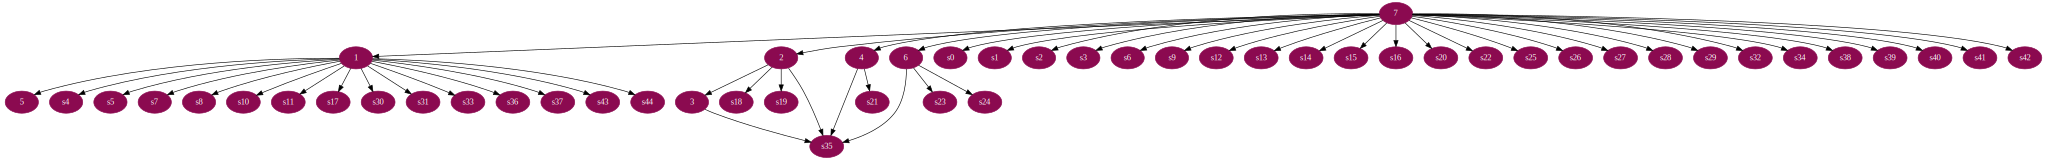

In [28]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
g

# Decorate the nodes

In [16]:
mix_clones_colors(n, clones_purity)

array([0, 0, 0])

In [17]:
def rgb_to_hex(colortuple):
    return '#' + ''.join(f'{int(i):02X}' for i in colortuple)

def mix_clones_colors(node_name, purities):
    node_purities = purities[node_name]
    color = 0
    for clone, frac in node_purities.iteritems():
        color += frac * np.array(clone_color[clone])
    return color.astype(int)


clones_count = dfs_clones_count(tree, clones_map, all_clones, source_node=get_root_node(tree))
clones_purity = purity(clones_count)

for n in tree.nodes:
    node_dict = tree.nodes[n]
    if n.startswith('s'):
        # This is the style for sample nodes
        clone = clones_map[n]
        node_dict['color'] = rgb_to_hex(clone_color[clone])
        node_dict['shape'] = 'circle' #square
    else:
        if n in clones_purity:
            # This is the style for mutation nodes
            # Color is a mix of purities
            node_dict['color'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
        else:
            # Dangling mutation node
            node_dict['color'] = 'black'

['42']


In [18]:
# Global graph style
tree.graph['node']['shape'] = 'square' #circle
tree.graph['node']['fontcolor'] = 'white'
tree.graph['edges'] = {'arrowsize': '4'}
tree.graph

{'name': 'G',
 'node': {'color': 'deeppink4',
  'style': 'filled',
  'fontcolor': 'white',
  'shape': 'square'},
 'edges': {'arrowsize': '4'}}

In [19]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)

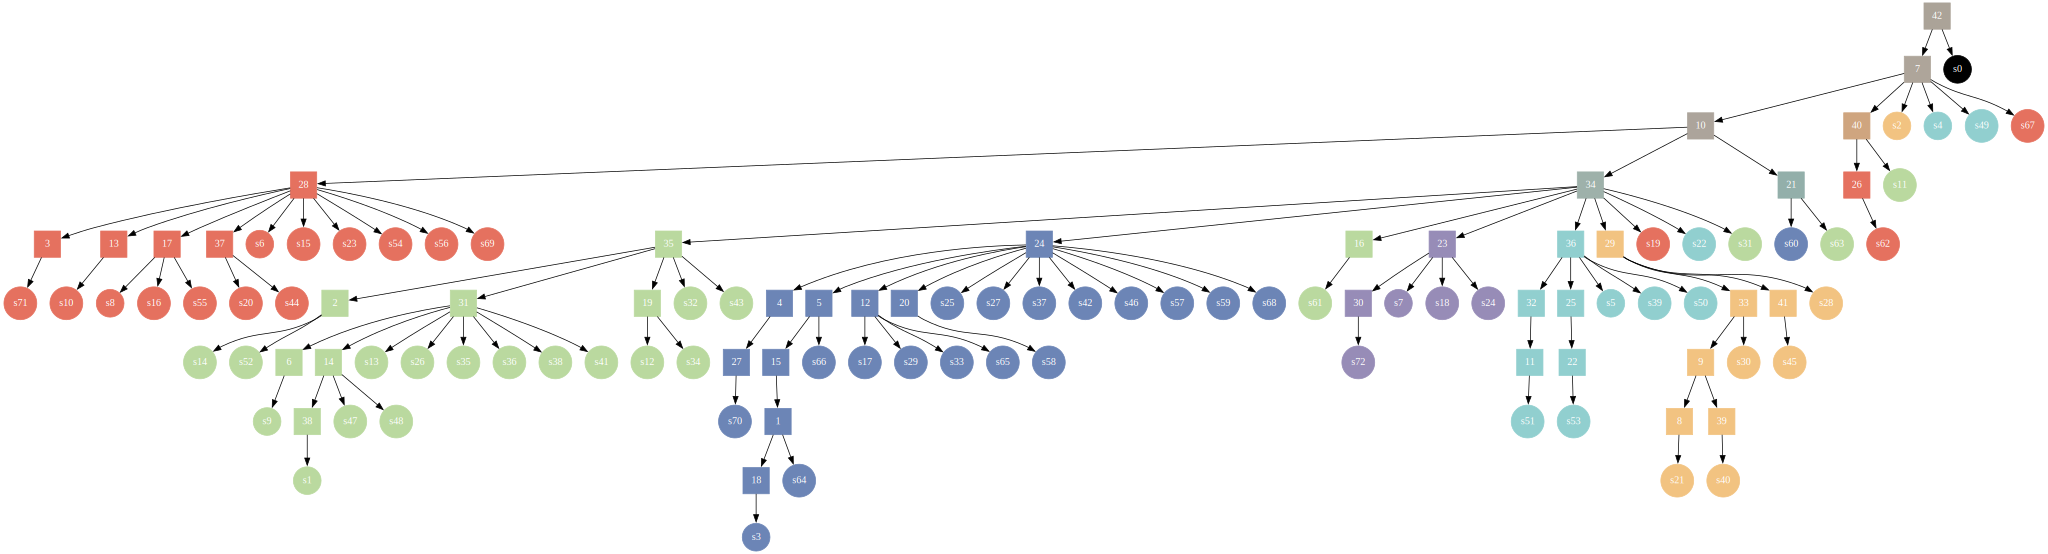

In [21]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)
g.layout('dot')
g.draw(f'../../data/YFV2001_figures/0.0556_map0.svg')
Source(g)